In [65]:
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, coo_matrix
from tqdm import tqdm
import numpy as np
import implicit
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt

# LSH and Bucketing

In [3]:
rating_df = pd.read_csv('Dataset/ratings.csv').astype(int)
rating_df

,userId,movieId,rating,timestamp
0,1,2,3,1112486027
1,1,29,3,1112484676
2,1,32,3,1112484819
3,1,47,3,1112484727
4,1,50,3,1112484580
...,...,...,...,...
20000258,138493,68954,4,1258126920
20000259,138493,69526,4,1259865108
20000260,138493,69644,3,1260209457
20000261,138493,70286,5,1258126944


In [3]:
def create_sparse_matrix(data):
    pivot_table = data.pivot(index='userId', columns='movieId', values='normalized_rating').fillna(0)
    return csr_matrix(pivot_table.values)

def normalize_data(data):
    mean_ratings = data.groupby('userId')['rating'].mean().reset_index(name='mean_rating')
    data = data.merge(mean_ratings, on='userId')
    data['normalized_rating'] = data['rating'] - data['mean_rating']
    data.drop(columns=['rating', 'mean_rating'], inplace=True, errors='ignore')
    return data, mean_ratings

In [4]:
def create_hash_vectors(length: int, count: int) -> list:
    return [np.random.uniform(-1, 1, size=length) for _ in range(count)]
        
def create_hash(vector: list, min_hash):
    result = []
    for hash in min_hash:
        a = np.dot(vector, hash) > 0
        result.append(1 if a else 0)
    return result

In [5]:
def calculate_bucket_number(hash_vector):
    s = ''.join(str(bit) for bit in hash_vector)
    bucket_number = int(s, 2)
    return bucket_number

# Neighbourhood Matrix

In [6]:
def create_neighborhood_matrix(new_user_vector, buckets, min_hash, sparse_matrix) -> csr_matrix:
    hash_vector = create_hash(new_user_vector, min_hash)
    bucket_number = calculate_bucket_number(hash_vector)

    if bucket_number in buckets:
        neighbor_users = buckets[bucket_number]
    else:
        return csr_matrix((0, sparse_matrix.shape[1]))
    
    rows = [sparse_matrix[n].toarray()[0] for n in neighbor_users]
    return csr_matrix(np.vstack(rows)) if rows else csr_matrix((0, sparse_matrix.shape[1]))

In [8]:
# def matrix_factorization(sparse_ratings: csr_matrix):
#     model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=64, use_native=True, num_threads=0)
#     model.fit(sparse_ratings.T, show_progress=False)
#     user_factors = model.user_factors
#     item_factors = model.item_factors
#     return item_factors @ user_factors.T

# def matrix_factorization(sparse_ratings: csr_matrix, k):
#     U, S, V = scipy.sparse.linalg.svds(sparse_ratings, k=k)
#     item_factors = U.dot(np.diag(S))
#     user_factors = V.T
#     factorization = item_factors.dot(user_factors.T)
#     factorization = item_factors @ user_factors.T
#     return factorization

from sklearn.utils.extmath import randomized_svd

def matrix_factorization(sparse_ratings: csr_matrix, k: int):
    U, S, V = randomized_svd(sparse_ratings, n_components=k)
    item_factors = U.dot(np.diag(S))
    user_factors = V
    factorization = item_factors.dot(user_factors)
    return factorization

# Rating Predictions

In [7]:
def pearson_correlation_coefficient(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays must be of the same length")
    
    mean1 = np.mean(array1)
    mean2 = np.mean(array2)
    
    centered1 = array1 - mean1
    centered2 = array2 - mean2
    
    covariance = np.sum(centered1 * centered2) / len(array1)
    std_dev1 = np.sqrt(np.sum(centered1**2) / len(array1))
    std_dev2 = np.sqrt(np.sum(centered2**2) / len(array2))
    
    if std_dev1 * std_dev2 == 0:
        return 0
    
    pearson_coefficient = covariance / (std_dev1 * std_dev2)
    
    return pearson_coefficient

In [9]:
def predict_ratings(user_vector, similar_users_count, buckets, min_hash, sparse_matrix):
    nm = create_neighborhood_matrix(user_vector, buckets, min_hash, sparse_matrix)
    min_shape = np.min(nm.shape)
    if min_shape == 0:
        return []
    k = int(0.5 * min_shape)
    if k < 1:
        k = 1
    if k == min_shape:
       return [] 
    neighborhood_matrix = matrix_factorization(nm, k)
    
    similarities = np.array([np.abs(pearson_correlation_coefficient(neighborhood_matrix[i], user_vector))
                             for i in range(neighborhood_matrix.shape[0])])
    
    similar_users = similarities.argsort()[::-1]
    user_mean = user_vector[user_vector != 0].mean()
    
    predicts = []
    for item_idx in range(neighborhood_matrix.shape[1]):
        if user_vector[item_idx] == 0:
            predicts.append(0)
            continue
        weighted_ratings_sum = 0
        weights_sum = 0
        users_added = 0
        for user_index in similar_users:
            if users_added == similar_users_count:
                break
            
            user_rating = neighborhood_matrix[user_index, item_idx]
            if user_rating == 0:
                continue
            users_added += 1
            similarity_score = similarities[user_index]
            weighted_ratings_sum += user_rating * similarity_score
            weights_sum += np.abs(similarity_score)
        
        predicted_rating = weighted_ratings_sum / weights_sum if weights_sum > 0 else 0
        predicts.append(predicted_rating + user_mean)
    
    return np.array(predicts)

# Cross Validation

In [10]:
def df_to_sparse(rating_df, df, key= 'normalized_rating'):
    unique_user_ids = pd.Series(rating_df['userId'].unique()).sort_values()
    user_mapping = pd.Series(index=unique_user_ids, data=range(len(unique_user_ids)))

    unique_movie_ids = pd.Series(rating_df['movieId'].unique()).sort_values()
    movie_mapping = pd.Series(index=unique_movie_ids, data=range(len(unique_movie_ids)))
    
    user_indices = df['userId'].map(user_mapping)
    movie_indices = df['movieId'].map(movie_mapping)
    values = df[key]

    result = coo_matrix((values, (user_indices, movie_indices)), 
                    shape=(len(user_mapping), len(movie_mapping)))
    print(result.shape)
    print(result.count_nonzero())
    return result.tocsr()

In [12]:
unique_users = rating_df['userId'].unique()
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = 1
total_loss = 0
for train_index, val_index in kf.split(unique_users):
    time.sleep(10)
    train_users = unique_users[train_index]
    val_users = unique_users[val_index]
    
    train_data = rating_df[rating_df['userId'].isin(train_users)]
    val_data = rating_df[rating_df['userId'].isin(val_users)]

    train_data, mean_ratings_train = normalize_data(train_data)
    train_sparse_matrix = df_to_sparse(rating_df, train_data)

    val_sparse_matrix = df_to_sparse(rating_df, val_data, 'rating')

    min_hash = create_hash_vectors(train_sparse_matrix.shape[1], 14)
    buckets = {}
    for i in tqdm(range(train_sparse_matrix.shape[0]), desc='Bucketing'):
        user = train_sparse_matrix[i].toarray()[0]
        hash_vector = create_hash(user, min_hash)
        bucket_number = calculate_bucket_number(hash_vector)
        if bucket_number not in buckets:
            buckets[bucket_number] = []
        buckets[bucket_number].append(i)

    desire_indices = []
    for i in range(val_sparse_matrix.shape[0]):
        ith = val_sparse_matrix[i]
        if ith.count_nonzero() > 0:
            desire_indices.append(i)
            
    time.sleep(10)

    loss = 0
    processed_count = 0
    
    for idx, i in enumerate(desire_indices):
      if idx == int(0.5 * len(desire_indices)):
        print('50% progress')
      user_vector = val_sparse_matrix[i].toarray()[0]
      if user_vector.sum() == 0:
          continue
      predicted = predict_ratings(user_vector, 20, buckets, min_hash, train_sparse_matrix)
      if len(predicted) == 0:
          continue

      mask = user_vector != 0
      actual = user_vector[mask]
      pred = predicted[mask]
      user_loss = np.mean((actual - pred) ** 2)
      loss += user_loss
      processed_count += 1
        
    print(f'Fold {fold} Loss: {loss}')
    fold += 1

    loss /= processed_count
    total_loss += loss

    print(f'Validation Loss: {loss}')

average_loss = total_loss / n_splits
print(f'Average Cross-Validation Loss: {average_loss}')

(138493, 26744)
17935929
(138493, 26744)
1985928


Bucketing: 100%|██████████| 138493/138493 [00:44<00:00, 3127.41it/s]


50% progress
Fold 1 Loss: 12056.729804501523
Validation Loss: 0.8902554681017147
(138493, 26744)
17903857
(138493, 26744)
2019027


Bucketing: 100%|██████████| 138493/138493 [00:27<00:00, 5125.31it/s]


50% progress
Fold 2 Loss: 12123.43903131032
Validation Loss: 0.8855689577290226
(138493, 26744)
17952425
(138493, 26744)
1970491


Bucketing: 100%|██████████| 138493/138493 [00:25<00:00, 5402.64it/s]


50% progress
Fold 3 Loss: 12047.394200410943
Validation Loss: 0.8862287921443978
(138493, 26744)
17967287
(138493, 26744)
1953751


Bucketing: 100%|██████████| 138493/138493 [00:25<00:00, 5371.95it/s]


50% progress
Fold 4 Loss: 12064.82412206025
Validation Loss: 0.8824476391208492
(138493, 26744)
17980433
(138493, 26744)
1947154


Bucketing: 100%|██████████| 138493/138493 [00:25<00:00, 5534.30it/s]


50% progress
Fold 5 Loss: 12033.564882568275
Validation Loss: 0.8885449961284999
(138493, 26744)
17952576
(138493, 26744)
1970407


Bucketing: 100%|██████████| 138493/138493 [00:25<00:00, 5353.22it/s]


50% progress
Fold 6 Loss: 12115.45611693077
Validation Loss: 0.8853091791692197
(138493, 26744)
17950604
(138493, 26744)
1972734


Bucketing: 100%|██████████| 138493/138493 [00:26<00:00, 5230.36it/s]


50% progress
Fold 7 Loss: 12049.74131657642
Validation Loss: 0.8804428844495411
(138493, 26744)
17997174
(138493, 26744)
1926122


Bucketing: 100%|██████████| 138493/138493 [00:26<00:00, 5293.03it/s]


50% progress
Fold 8 Loss: 12134.076460141361
Validation Loss: 0.8914249529930474
(138493, 26744)
17903495
(138493, 26744)
2018993


Bucketing: 100%|██████████| 138493/138493 [00:26<00:00, 5161.08it/s]


50% progress
Fold 9 Loss: 12056.755484680109
Validation Loss: 0.882761420755609
(138493, 26744)
17924968
(138493, 26744)
1996531


Bucketing: 100%|██████████| 138493/138493 [00:26<00:00, 5160.98it/s]


50% progress
Fold 10 Loss: 12011.526628983558
Validation Loss: 0.8809333794634072
Average Cross-Validation Loss: 0.8853917670055308


# Instagram Data

In [22]:
instagram_df = pd.read_csv('Instagram/common_user_ratings.csv')
instagram_df.rename(columns={'username': 'userId', 'page': 'movieId', 'score': 'rating'}, inplace=True)
instagram_df

,userId,movieId,rating
0,theengineersfm,wired,0.3
1,theengineersfm,techcrunch,0.3
2,mirhanealecian,digitaltrends,0.3
3,mirhanealecian,techcrunch,0.3
4,mirhanealecian,openai,0.3
...,...,...,...
852,abodk7aled,python.hub,0.2
853,abodk7aled,javascript.js,0.2
854,viktorhonchar,linux.teach,0.2
855,viktorhonchar,javascript.js,0.2


In [37]:
def matrix_factorization(sparse_ratings: csr_matrix, k):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = implicit.als.AlternatingLeastSquares(factors=k, regularization=0.1, iterations=64, use_native=True, num_threads=0)
        model.fit(sparse_ratings.T, show_progress=False)
        user_factors = model.user_factors
        item_factors = model.item_factors
        return item_factors @ user_factors.T

In [40]:
unique_users = instagram_df['userId'].unique()
train_users, val_users = train_test_split(unique_users, test_size=0.1, random_state=42)

train_data = instagram_df[instagram_df['userId'].isin(train_users)]
val_data = instagram_df[instagram_df['userId'].isin(val_users)]

train_data, mean_ratings_train = normalize_data(train_data)
train_sparse_matrix = df_to_sparse(instagram_df, train_data)

val_sparse_matrix = df_to_sparse(instagram_df, val_data, 'rating')

min_hash = create_hash_vectors(train_sparse_matrix.shape[1], 3)
buckets = {}
for i in tqdm(range(train_sparse_matrix.shape[0]), desc='Bucketing'):
    user = train_sparse_matrix[i].toarray()[0]
    hash_vector = create_hash(user, min_hash)
    bucket_number = calculate_bucket_number(hash_vector)
    if bucket_number not in buckets:
        buckets[bucket_number] = []
    buckets[bucket_number].append(i)

desire_indices = []
for i in range(val_sparse_matrix.shape[0]):
    ith = val_sparse_matrix[i]
    if ith.count_nonzero() > 0:
        desire_indices.append(i)
        

loss = 0
processed_count = 0
predicted_matrix = np.zeros(val_sparse_matrix.shape)

for idx, i in enumerate(desire_indices):
    user_vector = val_sparse_matrix[i].toarray()[0]
    if user_vector.sum() == 0:
        continue
    predicted = predict_ratings(user_vector, 20, buckets, min_hash, train_sparse_matrix)
    if len(predicted) == 0:
        continue
    
    predicted_matrix[i, :] = predicted

    mask = user_vector != 0
    actual = user_vector[mask]
    pred = predicted[mask]
    user_loss = np.mean((actual - pred) ** 2)
    loss += user_loss
    processed_count += 1

loss /= processed_count
print(f'Validation Loss: {loss}')

(386, 30)
135
(386, 30)
88


Bucketing: 100%|██████████| 386/386 [00:00<00:00, 7094.66it/s]


Validation Loss: 1.5802502107792704e-34


In [55]:
non_zero_indices = np.nonzero(predicted_matrix)
matrix = instagram_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
rows, cols = non_zero_indices

non_zero_values = []
for row, col in zip(rows, cols):
    userId = matrix.index[row]
    movieId = matrix.columns[col]
    nonZeroValue = predicted_matrix[row, col]
    non_zero_values.append((userId, movieId, nonZeroValue))
non_zero_values

[('0btuseprocessor', 'cnet', 0.2),
 ('0btuseprocessor', 'digitaltrends', 0.2),
 ('adamsarwar', 'techcrunch', 0.2),
 ('adamsarwar', 'wired', 0.2),
 ('add12', 'insidertech', 0.20000000000000004),
 ('add12', 'mashable', 0.20000000000000004),
 ('add12', 'techcrunch', 0.20000000000000004),
 ('afoteyannum', 'androidauthority', 0.20000000000000004),
 ('afoteyannum', 'mkbhd', 0.20000000000000004),
 ('afoteyannum', 'techcrunch', 0.20000000000000004),
 ('agentwalker', 'mashable', 0.2),
 ('agentwalker', 'verge', 0.2),
 ('alberto.dsc', 'gitHub', 0.2),
 ('alberto.dsc', 'techcrunch', 0.2),
 ('allmightsgone', 'microsoft', 0.2),
 ('allmightsgone', 'techradar', 0.2),
 ('astroeconomist', 'techcrunch', 0.2),
 ('astroeconomist', 'wired', 0.2),
 ('barefooteddragonkick', 'digitaltrends', 0.20000000000000004),
 ('barefooteddragonkick', 'engadget', 0.20000000000000004),
 ('barefooteddragonkick', 'mashable', 0.20000000000000004),
 ('caulmseh', 'androidcentral', 0.2),
 ('caulmseh', 'mashable', 0.2),
 ('deborahn

In [68]:
non_zero_df = pd.DataFrame(non_zero_values, columns=['username', 'page', 'score'])
def set_action(row):
    if row['score'] < 0.15:
        return 'none'
    if 0.15 <= row['score'] <= 0.25:
        return 'comment/like'
    elif 0.25 <= row['score'] <= 0.35:
        return 'follow'
    elif row['score'] > 0.35:
        return 'follow/like/comment'
    else:
        return None
    
non_zero_df['action'] = non_zero_df.apply(set_action, axis=1)

In [69]:
non_zero_df

,username,page,score,action
0,0btuseprocessor,cnet,0.2,comment/like
1,0btuseprocessor,digitaltrends,0.2,comment/like
2,adamsarwar,techcrunch,0.2,comment/like
3,adamsarwar,wired,0.2,comment/like
4,add12,insidertech,0.2,comment/like
...,...,...,...,...
83,varkeyjoshy,unboxtherapy,0.2,comment/like
84,wlrs_ocean,techcrunch,0.2,comment/like
85,wlrs_ocean,wired,0.2,comment/like
86,yokoshh,alcontech,0.3,follow


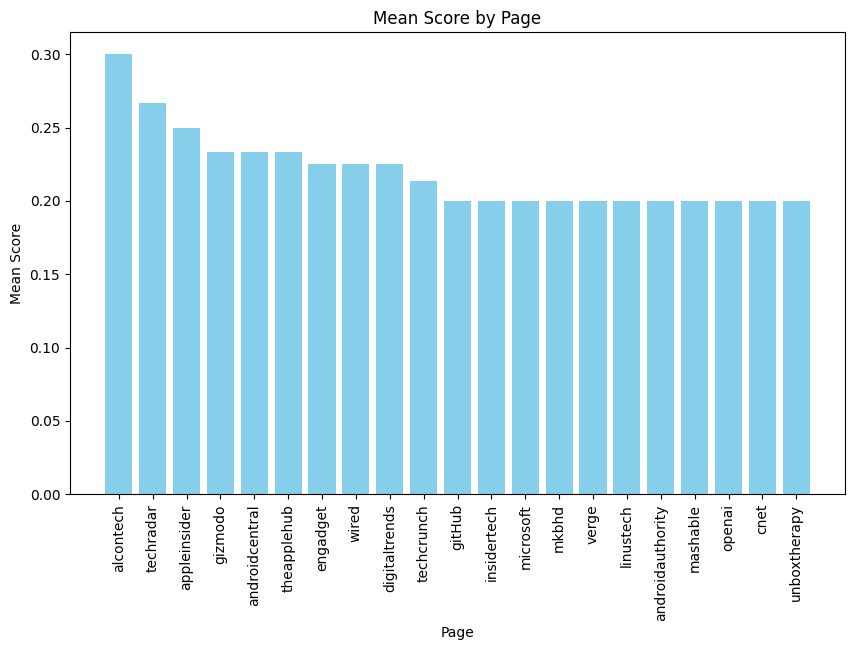

In [72]:
grouped_df = non_zero_df.groupby('page')['score'].mean().reset_index()
sorted_df = grouped_df.sort_values('score', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(sorted_df['page'], sorted_df['score'], color='skyblue')
plt.xlabel('Page')
plt.ylabel('Mean Score')
plt.title('Mean Score by Page')
plt.xticks(rotation=90)
plt.show()

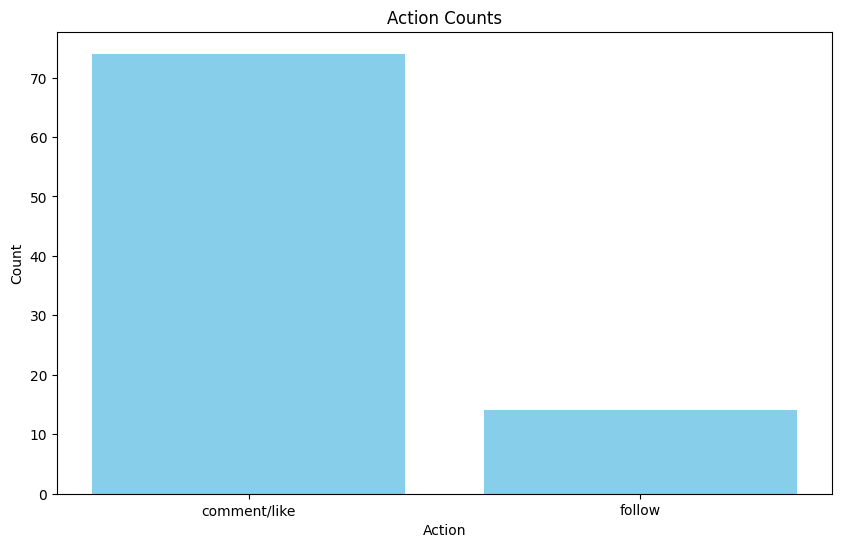

In [73]:
action_counts = non_zero_df['action'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(action_counts.index, action_counts.values, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Action Counts')
plt.show()